# 컨브넷을 사용한 시퀀스 처리

keras 에서 1D 컨브넷은 Conv1D 층을 이용하여 구현한다.  
합성곱 윈도우는 시간 축의 1D 윈도우  

IMDB 감성 분류 문제에 적용해보자

In [1]:
# from tensorflow.keras.datasets import imdb
# from tensorflow.keras.preprocessing import sequence
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('데이터 로드')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), '훈련 시퀀스')
print(len(x_test), '텍스트 시퀀스')

print('시퀀스 패딩 (samples * time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train 크기:', x_train.shape)
print('x_test 크기:', x_test.shape)

데이터 로드


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/nahyeonan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/nahyeonan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If

25000 훈련 시퀀스
25000 텍스트 시퀀스
시퀀스 패딩 (samples * time)
x_train 크기: (25000, 500)
x_test 크기: (25000, 500)


Conv1D와 MaxPooling1D 층을 쌓고 전역 풀링 층 또는 Flatten 층으로 마친다.  
3D 입력을 2D 출력으로 바꾸어 Dense 층을 추가할 수 있다.  

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
# 1D 윈도우 크기 : 7 (7개의 특성을 고려함)
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2,
                    verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

In [6]:
from matplotlib import rc 
rc('font',family='AppleGothic')

import matplotlib.pyplot as plt

def drawHistory(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    if 'acc' in history.history:
        
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        
        plt.plot(epochs, acc, 'ro', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()
    

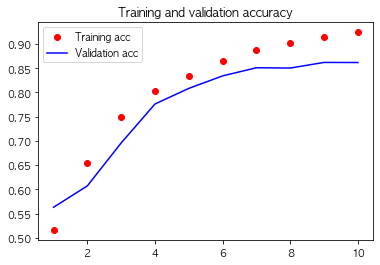

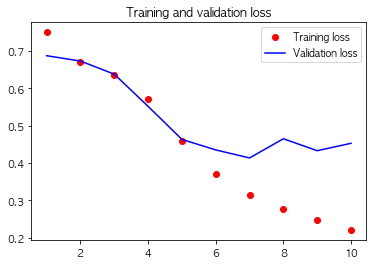

In [4]:
drawHistory(history)

## CNN과 RNN을 연결하여 긴 시퀀스를 처리하기 

1D convnet 은 입력 패치를 독립적으로 처리함  
타임스텝의 순서에 민감하지 않다.  

온도 예측 문제에 1D ConvNet을 적용해보자.  

In [1]:
import os

data_dir = './datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname, 'r') as f:
    data = f.read()
    
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [2]:
def generator(data, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows),
                          lookback // step,
                          data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

위: 08-3 에서 온도 예측에서 사용했던 코드를 그대로 가져온다.  

In [3]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data, 
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

# 추출 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', 
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), 
              loss='mae')

history = model.fit(train_gen, 
                    steps_per_epoch=500,
                    epochs=20, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

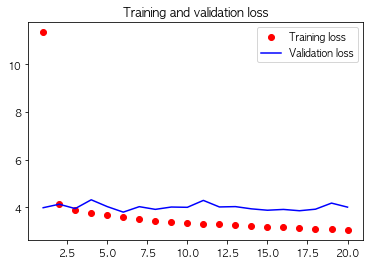

In [7]:
drawHistory(history)

In [8]:
# data generator
lookback = 1440
step = 3  # 이전에는 6
delay = 144

train_gen = generator(float_data, 
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)

val_gen = generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    shuffle=True,
                    step=step)

test_gen = generator(float_data, 
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     shuffle=True,
                     step=step)

# 추출 횟수
val_steps = (300000 - 200001 - lookback) // 128

test_steps = (len(float_data) - 300001 - lookback) // 128

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', 
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen,
                   steps_per_epoch=500,
                   epochs=20,
                   validation_data=val_gen,
                   validation_steps=val_steps)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 69s 135ms/step - loss: 7.4388 - val_loss: 4.3595
Epoch 2/20
50

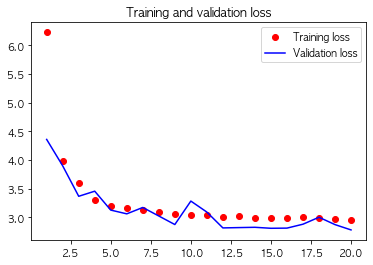

In [10]:
drawHistory(history)